# Exploring the evolution of lap and pole times for Silverstone, Monza and Monaco

### Table of Contents
* [Introduction](#Intro)
* [Importing the Data](#Data)
    * [Limiting Kaggle Data to Silverstone, Monza and Monaco](#section2_1)
    * [gp racing stats Dataset Heads](#section1_2)
* [Qualifying Times](#Quali)
    * [Kaggle Data](#section3_1)
    * [Kaggle Data Plots](#section3_2)
    * [gp racing stats Data](#section3_3)
    * [gp racing stats Plots](#section3_4)
* [Fastest Lap Average Speeds](#Speeds)
    * [Average Speed Plots](#Speeds_1)
* [Fastest Lap Times](#Fastest_laps)
    * [Fastest Lap Plot](#Fastest_laps_1)
* [Creating and Exporting Combined table](#Combined)
* [Conclusion](#Conc)

### Introduction <a class="anchor" id="Intro"></a>

In this notebook we will explore the data on Fastest Laps and Qualifying pole times for three tracks Silverstone, Monza, and Monaco.

These tracks were chosen because they have seen almost continuous racing year on year since Formula 1's inception in 1950.

Questions we are looking to answer include:
- How has the pace of the cars evolved?
- Have they evolved at the same pace for each track?

### Importing the Data <a class="anchor" id="Data"></a>
First up we will load in the required libraries and data

In [462]:
#Import Librabies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [463]:
## Loading in the datasets

#Kaggle Data
circuits = pd.read_csv("kaggle_data//circuits.csv")
constructor_results = pd.read_csv("kaggle_data//constructor_results.csv")
constructor_standings = pd.read_csv("kaggle_data//constructor_standings.csv")
constructors = pd.read_csv("kaggle_data//constructors.csv")
driver_standings = pd.read_csv("kaggle_data//driver_standings.csv")
drivers = pd.read_csv("kaggle_data//drivers.csv")
lap_times = pd.read_csv("kaggle_data//lap_times.csv")
qualifying = pd.read_csv("kaggle_data//qualifying.csv")
results = pd.read_csv("kaggle_data//results.csv")
races = pd.read_csv("kaggle_data//races.csv")

#gp racing stats Data
silverstone_poles_data = pd.read_csv("gpracingstats_data//silverstone_poles_data.csv")
monza_poles_data = pd.read_csv("gpracingstats_data//monza_poles_data.csv")
monaco_poles_data = pd.read_csv("gpracingstats_data//monaco_poles_data.csv")
monza_fastest_lap_data = pd.read_csv("gpracingstats_data//monza_fastest_lap_data.csv")
silverstone_fastest_lap_data = pd.read_csv("gpracingstats_data//silverstone_fastest_lap_data.csv")
monaco_fastest_lap_data = pd.read_csv("gpracingstats_data//monaco_fastest_lap_data.csv")

#### Limiting to Silverstone, Monza and Monaco <a class="anchor" id="section2_1"></a>

This step is only required for the kaggle data sets, since our gp racing stats data are already split by circuit.

In [464]:
#find Silverstone, Monza and Monaco ID's and limit data to these tracks
circuits.circuitRef.unique()

array(['albert_park', 'sepang', 'bahrain', 'catalunya', 'istanbul',
       'monaco', 'villeneuve', 'magny_cours', 'silverstone',
       'hockenheimring', 'hungaroring', 'valencia', 'spa', 'monza',
       'marina_bay', 'fuji', 'shanghai', 'interlagos', 'indianapolis',
       'nurburgring', 'imola', 'suzuka', 'vegas', 'yas_marina', 'galvez',
       'jerez', 'estoril', 'okayama', 'adelaide', 'kyalami', 'donington',
       'rodriguez', 'phoenix', 'ricard', 'yeongam', 'jacarepagua',
       'detroit', 'brands_hatch', 'zandvoort', 'zolder', 'dijon',
       'dallas', 'long_beach', 'las_vegas', 'jarama', 'watkins_glen',
       'anderstorp', 'mosport', 'montjuic', 'nivelles', 'charade',
       'tremblant', 'essarts', 'lemans', 'reims', 'george', 'zeltweg',
       'aintree', 'boavista', 'riverside', 'avus', 'monsanto', 'sebring',
       'ain-diab', 'pescara', 'bremgarten', 'pedralbes', 'buddh',
       'americas', 'red_bull_ring', 'sochi', 'baku', 'portimao',
       'mugello', 'jeddah', 'losail', 

In [465]:
circuits[(circuits.circuitRef == "monaco") | (circuits.circuitRef == "monza") | (circuits.circuitRef == "silverstone") ]

,circuitId,circuitRef,name,location,country,lat,lng,alt,url
5,6,monaco,Circuit de Monaco,Monte-Carlo,Monaco,43.7347,7.42056,7,http://en.wikipedia.org/wiki/Circuit_de_Monaco
8,9,silverstone,Silverstone Circuit,Silverstone,UK,52.0786,-1.01694,153,http://en.wikipedia.org/wiki/Silverstone_Circuit
13,14,monza,Autodromo Nazionale di Monza,Monza,Italy,45.6156,9.28111,162,http://en.wikipedia.org/wiki/Autodromo_Naziona...


Now we know that Monaco has circuit id of 6, Monza is 14 and Silverstone is 9. Next we limit the races database only these tracks.

In [466]:
#Limiting races to these tracks
races_limited = races[(races.circuitId.isin([6,9,14]))]

#Drop down races_limited to just the columns we need
races_limited = races_limited[["raceId", "year", "circuitId", "name"]]

### Qualifying Pole Times <a class="anchor" id="Quali"></a>

#### Kaggle Data <a class="anchor" id="section3_1"></a>
We will first exlore the Kaggle data, this data is only from 1994 which will become apparent as we work with the data.

In [467]:
#Inspect layout of qualifying dataframe
print(qualifying.head())

   qualifyId  raceId  driverId  constructorId  number  position        q1  \
0          1      18         1              1      22         1  1:26.572   
1          2      18         9              2       4         2  1:26.103   
2          3      18         5              1      23         3  1:25.664   
3          4      18        13              6       2         4  1:25.994   
4          5      18         2              2       3         5  1:25.960   

         q2        q3  
0  1:25.187  1:26.714  
1  1:25.315  1:26.869  
2  1:25.452  1:27.079  
3  1:25.691  1:27.178  
4  1:25.518  1:27.236  


To continue our analysis, we need to rework qualifying session times from q1 and q3 into a seconds format. To do this we split on the colon and then convert to float values.

In [468]:
#Converting q3 to a time in seconds and making column float
q3_split = qualifying.q3.str.split(":")
qualifying["q3min"] = q3_split.str.get(0)
qualifying["q3sec"] = q3_split.str.get(1)
qualifying["q3min"] = qualifying["q3min"].astype("float")
qualifying["q3sec"] = qualifying["q3sec"].astype("float")
qualifying["q3"] = 60*qualifying["q3min"] + qualifying["q3sec"]

q1_split = qualifying.q1.str.split(":")
qualifying["q1min"] = q1_split.str.get(0)
qualifying["q1sec"] = q1_split.str.get(1)
qualifying["q1min"] = qualifying["q1min"].astype("float")
qualifying["q1sec"] = qualifying["q1sec"].astype("float")
qualifying["q1"] = 60*qualifying["q1min"] + qualifying["q1sec"]

#Droping qualifying down to required columns
qualifying = qualifying[["qualifyId", "raceId", "driverId", "constructorId", "q1", "q3", "position"]]
qualifying.head()



,qualifyId,raceId,driverId,constructorId,q1,q3,position
0,1,18,1,1,86.572,86.714,1
1,2,18,9,2,86.103,86.869,2
2,3,18,5,1,85.664,87.079,3
3,4,18,13,6,85.994,87.178,4
4,5,18,2,2,85.960,87.236,5


Next we identify the pole sitters by looking only at position entry equaling 1st. Before dropping down to only Monaco, Monza and Silverstone.

In [469]:
#To find pole times, we limit to position = 1
qualifying_poles = qualifying[qualifying.position == 1]

#remove position column
qualifying_poles = qualifying_poles[["qualifyId", "raceId", "driverId", "constructorId", "q1", "q3"]]

In [470]:
#Drop down to Monaco, Monza and Silverstone
merged_df = qualifying_poles.merge(races_limited, how = "inner", on = "raceId")   

In the mid 2000's, Formula 1 saw a change in qualifying format, going from a single session: "q1", to 3 sessions: "q1", "q2" and "q3". 

To work around this. we make a new column called pole time, we assign it intially to q1 values, then we cycle through every row and if a q3 value is present (i.e. the new quali format) we assign q3 as the pole time.

In [471]:

#Create new pole time column, we want to assign it the q3 value if non null, otherwise we take q1, this is due to a change in qualifying formats
merged_df["pole_time"] = merged_df["q1"]

for i in range(len(merged_df)):
    entry = merged_df.iloc[i][5]
    if np.all(pd.notnull([entry])):
        merged_df.iat[i,9] = entry

In [472]:
#Rename merged_df and drop down to required columns
qualifying_pole_times = merged_df[["year", "circuitId", "name", "pole_time"]]

#Sort by year
qualifying_pole_times=qualifying_pole_times.sort_values(by=['year'])

#Split into Monaco, Silvestone and Monza
monaco_qualifying_pole_times = qualifying_pole_times[qualifying_pole_times.circuitId == 6]
monza_qualifying_pole_times = qualifying_pole_times[qualifying_pole_times.circuitId == 14]
silverstone_qualifying_pole_times = qualifying_pole_times[qualifying_pole_times.circuitId == 9]

In [473]:
monaco_qualifying_pole_times.year

17    1995
16    1996
14    1997
28    2003
31    2004
33    2005
6     2006
3     2007
0     2008
22    2009
25    2010
34    2011
36    2012
39    2013
43    2014
46    2015
49    2016
52    2017
55    2018
58    2019
64    2021
67    2022
70    2023
Name: year, dtype: int64

In [474]:
monaco_qualifying_pole_times.pole_time

17    81.952
16    80.356
14    78.216
28    75.259
31    73.985
33    73.644
6     73.962
3     75.726
0     75.787
22    74.902
25    73.826
34    73.556
36    74.301
39    73.876
43    75.989
46    75.098
49    73.622
52    72.178
55    70.810
58    70.166
64    70.346
67    71.376
70    71.365
Name: pole_time, dtype: float64

#### Exploring Kaggle Data Pole Time Plots <a class="anchor" id="section3_2"></a>

<IPython.core.display.Javascript object>


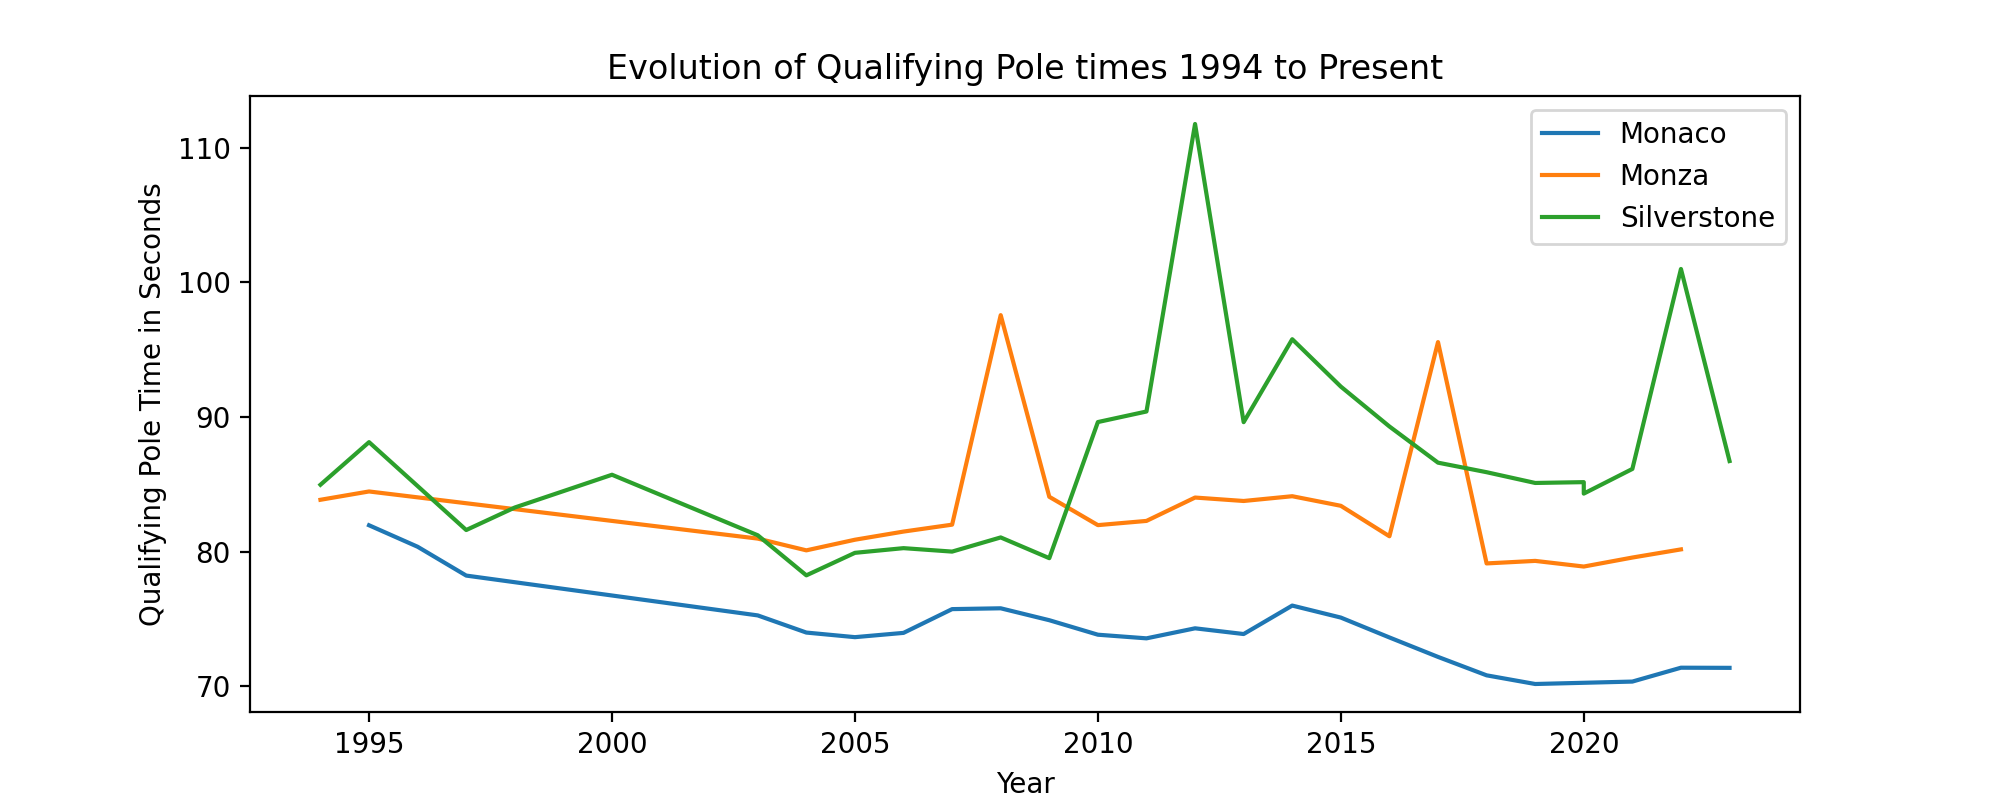

In [475]:
plt.figure(figsize = (10,4))
plt.plot(monaco_qualifying_pole_times.year,monaco_qualifying_pole_times.pole_time, label = "Monaco")
plt.plot(monza_qualifying_pole_times.year,monza_qualifying_pole_times.pole_time, label = "Monza")
plt.plot(silverstone_qualifying_pole_times.year,silverstone_qualifying_pole_times.pole_time, label = "Silverstone")
plt.legend()
plt.title("Evolution of Qualifying Pole times 1994 to Present")
plt.xlabel("Year")
plt.ylabel("Qualifying Pole Time in Seconds")
plt.show()


As we can see, the data only exists from 1994, even so we can still see that Monaco has the quickest decrease in times. However to explore before 1994, we will have to move onto the gp racing stats data.

### gp racing stats Data <a class="anchor" id="section3_3"></a>

In [476]:
silverstone_poles_data.head()

,year,grand_prix,driver,constructor,race,pole_margin,pole_time
0,1950,Britain,(ITA) Giuseppe Farina,Alfa Romeo,1,0.200s,1:50.800
1,1951,Britain,(ARG) Jose Froilan Gonzalez,Ferrari,1,1.000s,1:43.400
2,1952,Britain,(ITA) Giuseppe Farina,Ferrari,6,0.000s,1:50.000
3,1953,Britain,(ITA) Alberto Ascari,Ferrari,1,1.000s,1:48.000
4,1954,Britain,(ARG) Juan Manuel Fangio,Mercedes,4,1.000s,1:45.000


Akin to the kaggle data, we will need to split and reassemble the pole_time values to create a float value in seconds.

In [477]:
#Spliting and reformating the pole_time columns
silverstone_poles_data_split = silverstone_poles_data['pole_time'].str.split(":")
silverstone_poles_data["mins"] = silverstone_poles_data_split.str.get(0)
silverstone_poles_data["secs"] = silverstone_poles_data_split.str.get(1)
silverstone_poles_data["mins"] = silverstone_poles_data["mins"].astype("float")
silverstone_poles_data["secs"] = silverstone_poles_data["secs"].astype("float")
silverstone_poles_data["pole_time"] = 60*silverstone_poles_data["mins"] + silverstone_poles_data["secs"]
silverstone_poles_data = silverstone_poles_data[["year", "pole_time"]]

#rename column
silverstone_poles_data = silverstone_poles_data.rename(columns = {"pole_time": "silver_pole_time"})
print(silverstone_poles_data.head())


   year  silver_pole_time
0  1950             110.8
1  1951             103.4
2  1952             110.0
3  1953             108.0
4  1954             105.0


Next we repeat these steps for Monza and Monaco

In [478]:
monza_poles_data_split = monza_poles_data['pole_time'].str.split(":")
monza_poles_data["mins"] = monza_poles_data_split.str.get(0)
monza_poles_data["secs"] = monza_poles_data_split.str.get(1)
monza_poles_data["mins"] = monza_poles_data["mins"].astype("float")
monza_poles_data["secs"] = monza_poles_data["secs"].astype("float")
monza_poles_data["pole_time"] = 60*monza_poles_data["mins"] + monza_poles_data["secs"]
monza_poles_data = monza_poles_data[["year", "driver", "pole_time"]]

#rename column
monza_poles_data = monza_poles_data.rename(columns = {"pole_time": "monza_pole_time"})

In [479]:
monaco_poles_data_split = monaco_poles_data['pole_time'].str.split(":")
monaco_poles_data["mins"] = monaco_poles_data_split.str.get(0)
monaco_poles_data["secs"] = monaco_poles_data_split.str.get(1)
monaco_poles_data["mins"] = monaco_poles_data["mins"].astype("float")
monaco_poles_data["secs"] = monaco_poles_data["secs"].astype("float")
monaco_poles_data["pole_time"] = 60*monaco_poles_data["mins"] + monaco_poles_data["secs"]
monaco_poles_data = monaco_poles_data[["year", "driver", "pole_time"]]

#rename column
monaco_poles_data = monaco_poles_data.rename(columns = {"pole_time": "monaco_pole_time"})

### gp racing stats Pole Time Plot <a class="anchor" id="section3_4"></a>

<IPython.core.display.Javascript object>


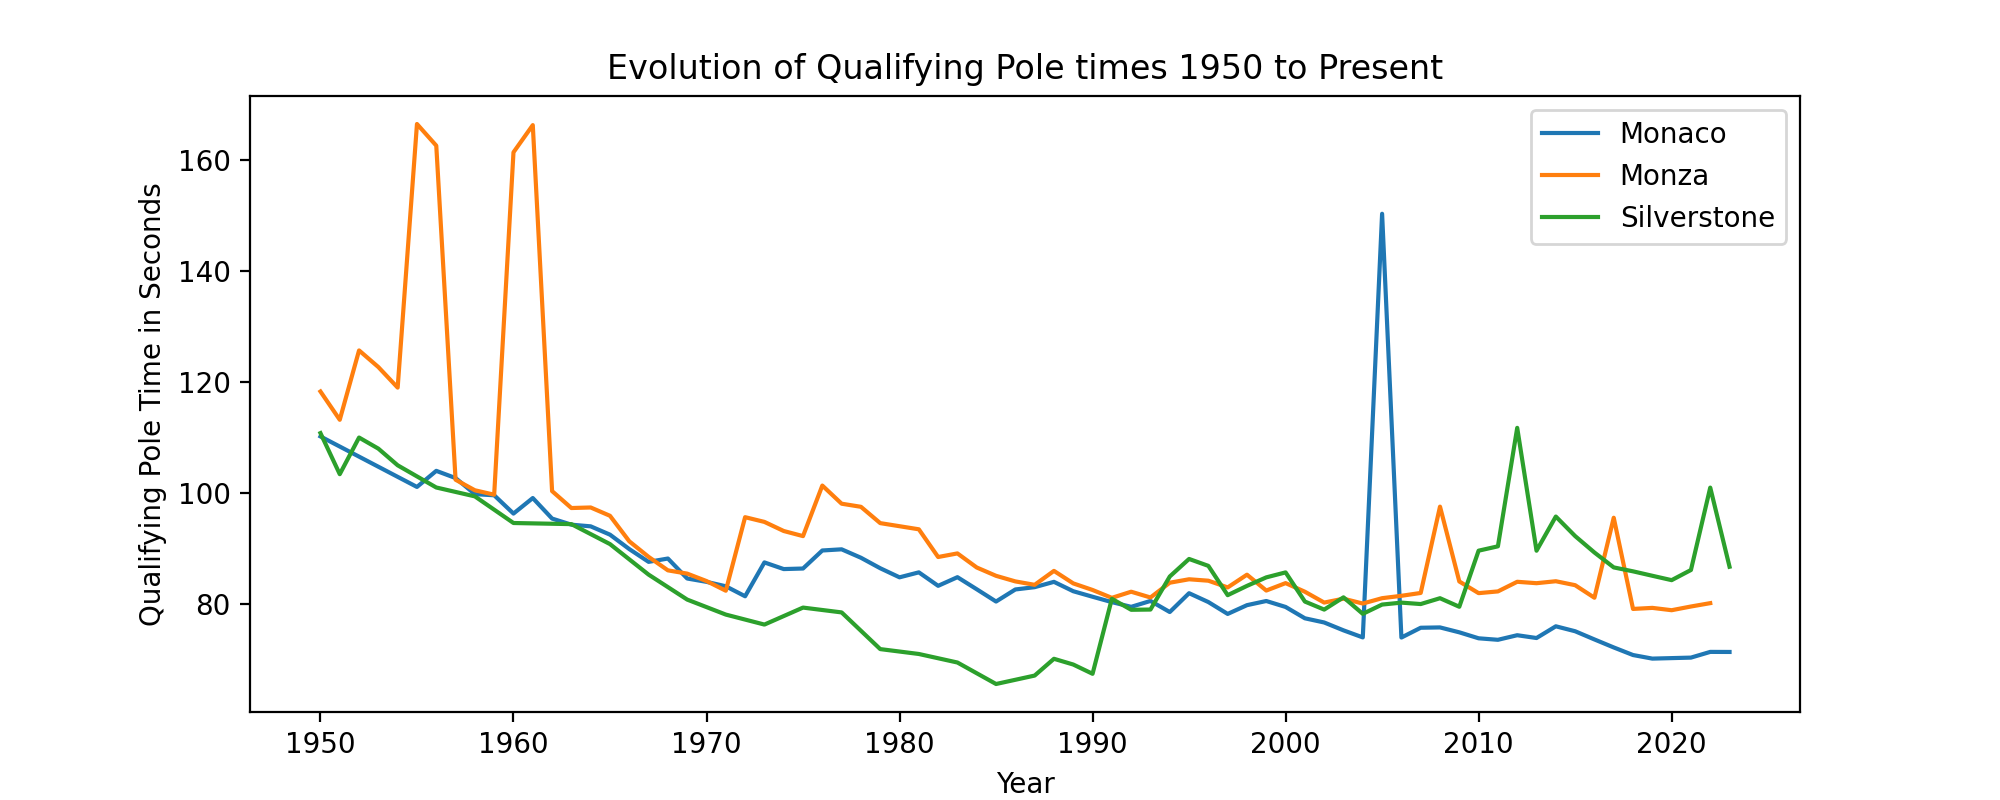

In [480]:
plt.figure(figsize = (10,4))
plt.plot(monaco_poles_data.year,monaco_poles_data.monaco_pole_time, label = "Monaco")
plt.plot(monza_poles_data.year,monza_poles_data.monza_pole_time, label = "Monza")
plt.plot(silverstone_poles_data.year,silverstone_poles_data.silver_pole_time, label = "Silverstone")

plt.legend()
plt.title("Evolution of Qualifying Pole times 1950 to Present")
plt.xlabel("Year")
plt.ylabel("Qualifying Pole Time in Seconds")
plt.show()


The steepest decliine on the plots comes from 1950 to the 1980's. From then on the times remain reasonably flat. It is worth noting that track layouts have changed and been updates for all 3 tracks, such as Silverstone in 2010, with this knowledge it is more pressing to look at the overall trends between layout changes.

The large time spikes here are very likely to be attributed to wet conditions.

# Fastest Lap Average Speeds <a class="anchor" id="Speeds"></a>

Next we will delve into the average speed across the fastest lap in each race. Average speed is a stronger metric since it is not nearly as influenced by layout changes as overall lap time. Hopefully allowing us to make stronger conclusions.

In [481]:
#Checking the data types in the results data
results.dtypes

resultId             int64
raceId               int64
driverId             int64
constructorId        int64
number             float64
grid                 int64
position           float64
positionText        object
positionOrder        int64
points             float64
laps                 int64
time                object
milliseconds       float64
fastestLap         float64
rank               float64
fastestLapTime      object
fastestLapSpeed    float64
statusId             int64
dtype: object

In [482]:
#Changing fastest lap speed to float
results.fastestLapSpeed = results.fastestLapSpeed.astype("float64")

#Grouping per racea and selecting the fastest speed
grouped_results = results.groupby("raceId").max("fastestLapSpeed")

#drop down to require columns
grouped_results = grouped_results[["fastestLapSpeed"]]
grouped_results.head()

,fastestLapSpeed
raceId,
1,217.668
2,206.483
3,174.289
4,206.049
5,202.484


Next, it becomes useful to merge the results and races tables so that we can see fastest lap speeds against the circuits and year in one table

In [483]:
results_races_merged = grouped_results.merge(races, on = "raceId")

#Dropping down to required columns
results_races_merged = results_races_merged[["raceId", "fastestLapSpeed", "year", "circuitId", "name"]]
results_races_merged = results_races_merged.sort_values(by = "year")
results_races_merged.head()

,raceId,fastestLapSpeed,year,circuitId,name
838,839,NaN,1950,14,Italian Grand Prix
837,838,NaN,1950,55,French Grand Prix
836,837,NaN,1950,13,Belgian Grand Prix
835,836,NaN,1950,66,Swiss Grand Prix
834,835,NaN,1950,19,Indianapolis 500


In [484]:
results_races_merged.isna().sum()

raceId               0
fastestLapSpeed    714
year                 0
circuitId            0
name                 0
dtype: int64

As we can see, unfortunately fastest lap speed is not recorded for every race and there are many null values present.

To make our lives easier before plotting, we split into the 3 tracks in question.

In [485]:
#partitioning by track
fastest_lap_speed_monaco = results_races_merged[results_races_merged.circuitId == 6]
fastest_lap_speed_monza = results_races_merged[results_races_merged.circuitId == 14]
fastest_lap_speed_silverstone = results_races_merged[results_races_merged.circuitId == 9]

#renaming fastest lap column within each
fastest_lap_speed_silverstone = fastest_lap_speed_silverstone.rename(columns = {"fastestLapSpeed": "silver_fastest_lap_speed"})
fastest_lap_speed_monza = fastest_lap_speed_monza.rename(columns = {"fastestLapSpeed": "monza_fastest_lap_speed"})
fastest_lap_speed_monaco = fastest_lap_speed_monaco.rename(columns = {"fastestLapSpeed": "monaco_fastest_lap_speed"})

### Plotting Fastest Lap Speeds <a class="anchor" id="Speeds_1"></a>

<IPython.core.display.Javascript object>


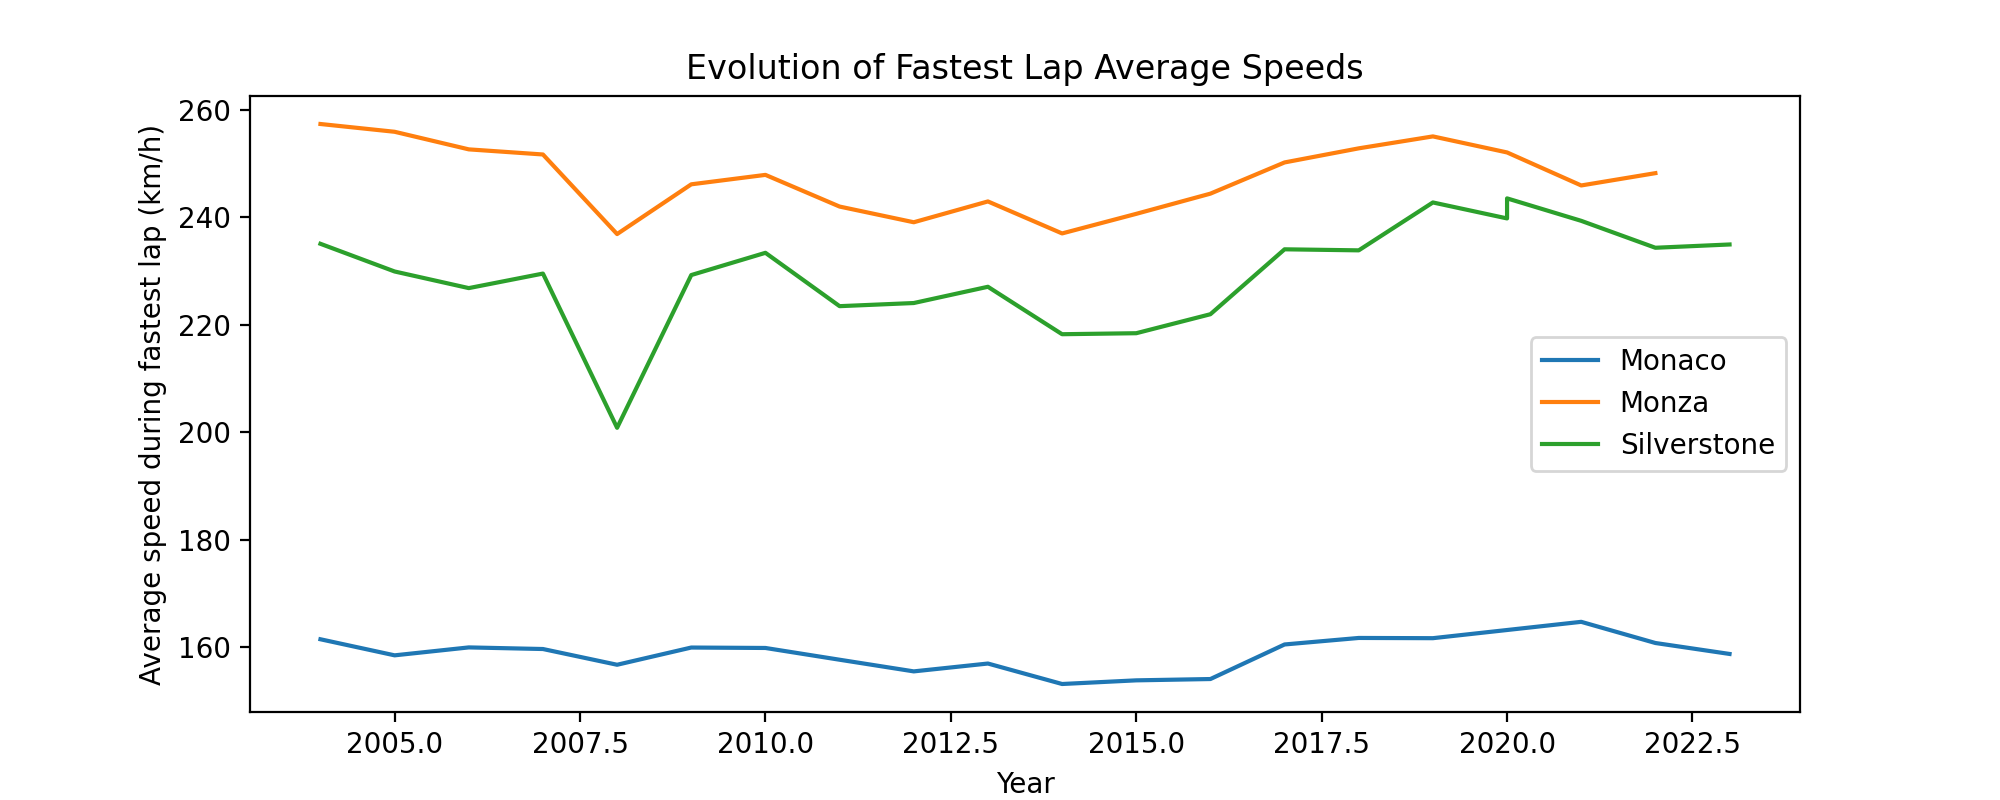

In [486]:

plt.figure(figsize=(10,4))
plt.plot(fastest_lap_speed_monaco.year,fastest_lap_speed_monaco.monaco_fastest_lap_speed, label = "Monaco")
plt.plot(fastest_lap_speed_monza.year,fastest_lap_speed_monza.monza_fastest_lap_speed, label = "Monza")
plt.plot(fastest_lap_speed_silverstone.year,fastest_lap_speed_silverstone.silver_fastest_lap_speed, label = "Silverstone")

plt.legend()
plt.title("Evolution of Fastest Lap Average Speeds")
plt.xlabel("Year")
plt.ylabel("Average speed during fastest lap (km/h)")
plt.show()


As suspected, the fastest lap speed data is only recorded from 2004.

Even so, we can still see that average speed remains relatively flat over the last two decades. Speeds have trended a little up over the last 5 years however this change is not significant.

## Fastest Lap Times <a class="anchor" id="Fastest_laps"></a>

Before digging into the data, we again need to change into seconds for all 3 data sets. Again we are using gp racing stats data.

In [487]:
monza_fastest_lap_data_split = monza_fastest_lap_data['lap_time'].str.split(":")
monza_fastest_lap_data["mins"] = monza_fastest_lap_data_split.str.get(0)
monza_fastest_lap_data["secs"] = monza_fastest_lap_data_split.str.get(1)
monza_fastest_lap_data["mins"] = monza_fastest_lap_data["mins"].astype("float")
monza_fastest_lap_data["secs"] = monza_fastest_lap_data["secs"].astype("float")
monza_fastest_lap_data["lap_time"] = 60*monza_fastest_lap_data["mins"] + monza_fastest_lap_data["secs"]
monza_fastest_lap_data = monza_fastest_lap_data[["year", "lap_time"]]
monza_fastest_lap_data = monza_fastest_lap_data.rename(columns = {"lap_time": "monza_fastest_lap_time"})

In [488]:
monaco_fastest_lap_data_split = monaco_fastest_lap_data['lap_time'].str.split(":")
monaco_fastest_lap_data["mins"] = monaco_fastest_lap_data_split.str.get(0)
monaco_fastest_lap_data["secs"] = monaco_fastest_lap_data_split.str.get(1)
monaco_fastest_lap_data["mins"] = monaco_fastest_lap_data["mins"].astype("float")
monaco_fastest_lap_data["secs"] = monaco_fastest_lap_data["secs"].astype("float")
monaco_fastest_lap_data["lap_time"] = 60*monaco_fastest_lap_data["mins"] + monaco_fastest_lap_data["secs"]
monaco_fastest_lap_data = monaco_fastest_lap_data[["year", "lap_time"]]
monaco_fastest_lap_data = monaco_fastest_lap_data.rename(columns = {"lap_time": "monaco_fastest_lap_time"})

In [489]:
silverstone_fastest_lap_data_split = silverstone_fastest_lap_data['lap_time'].str.split(":")
silverstone_fastest_lap_data["mins"] = silverstone_fastest_lap_data_split.str.get(0)
silverstone_fastest_lap_data["secs"] = silverstone_fastest_lap_data_split.str.get(1)
silverstone_fastest_lap_data["mins"] = silverstone_fastest_lap_data["mins"].astype("float")
silverstone_fastest_lap_data["secs"] = silverstone_fastest_lap_data["secs"].astype("float")
silverstone_fastest_lap_data["lap_time"] = 60*silverstone_fastest_lap_data["mins"] + silverstone_fastest_lap_data["secs"]
silverstone_fastest_lap_data = silverstone_fastest_lap_data[["year", "lap_time"]]
silverstone_fastest_lap_data = silverstone_fastest_lap_data.rename(columns = {"lap_time": "silver_fastest_lap_time"})

### Plotting Fastest Laps Data <a class="anchor" id="Fastest_laps_1"></a>

<IPython.core.display.Javascript object>


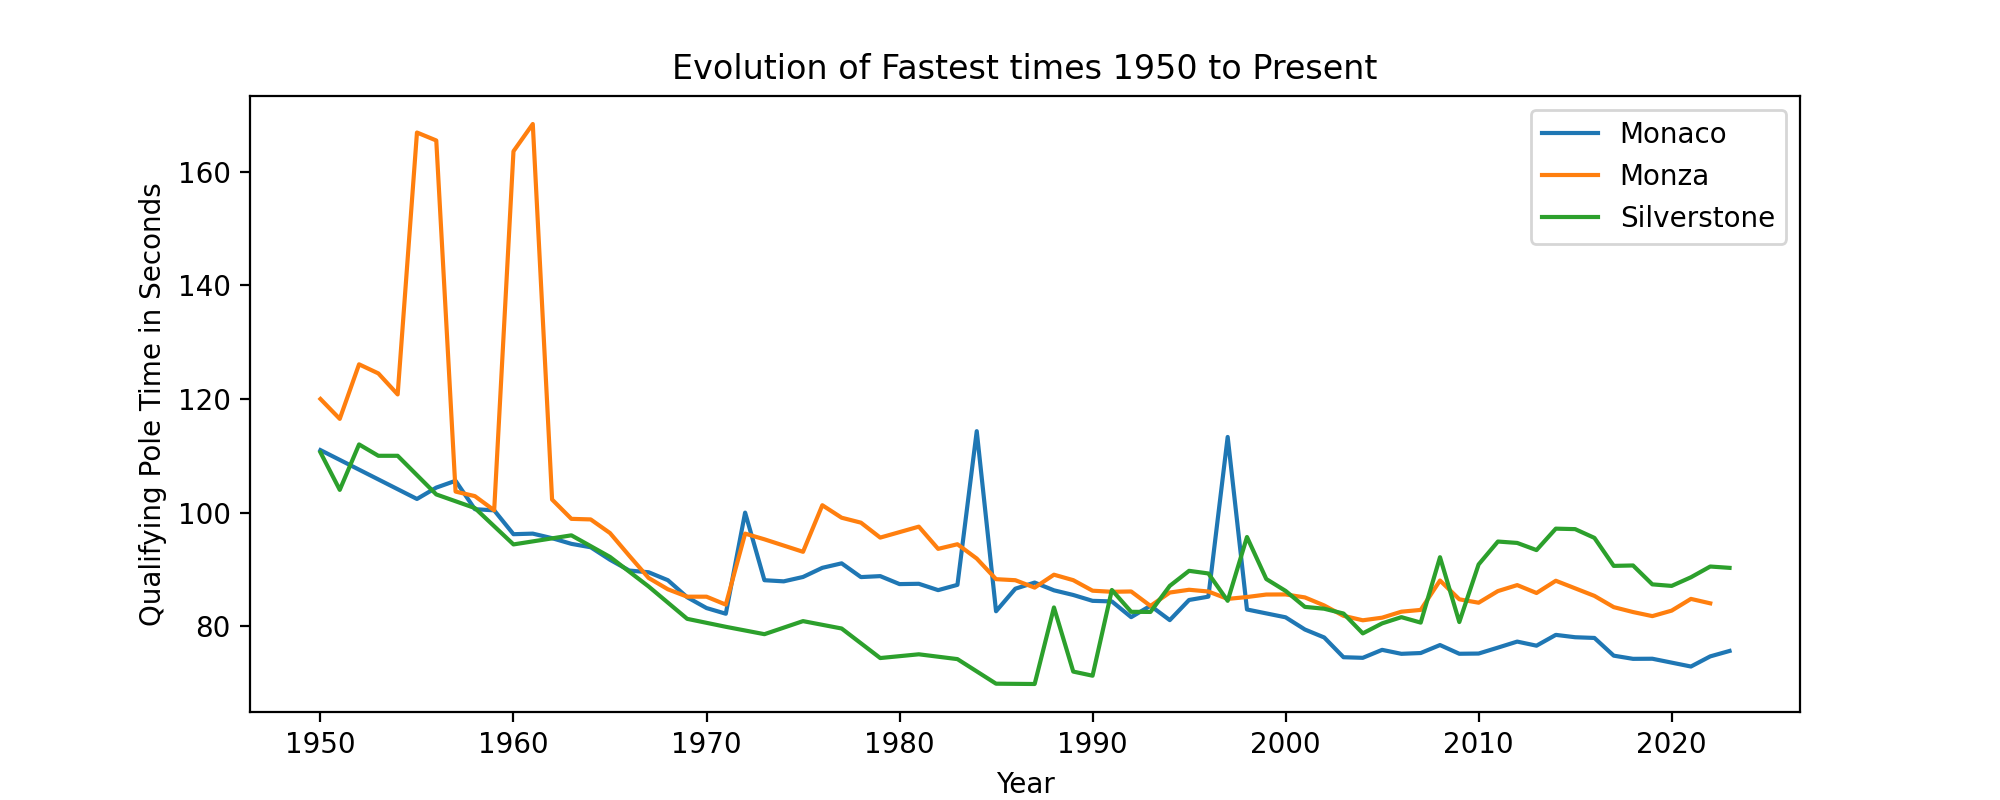

In [490]:

plt.figure(figsize = (10,4))
plt.plot(monaco_fastest_lap_data.year,monaco_fastest_lap_data.monaco_fastest_lap_time, label = "Monaco")
plt.plot(monza_fastest_lap_data.year,monza_fastest_lap_data.monza_fastest_lap_time, label = "Monza")
plt.plot(silverstone_fastest_lap_data.year,silverstone_fastest_lap_data.silver_fastest_lap_time, label = "Silverstone")

plt.legend()
plt.title("Evolution of Fastest times 1950 to Present")
plt.xlabel("Year")
plt.ylabel("Qualifying Pole Time in Seconds")
plt.show()


From the plot, we can see that Fastest lap times saw their fastest decrease from 1950 to the 1980s, as was reflected in the pole times data.

From the new century onwards times see little change, owing to a fast turn over of technical changes, keeping speeds within the same window.

### Creating Combined Table <a class="anchor" id="Combined"></a>
For the purposes of later analysis, it becomes useful to create and export a combined table.

In [491]:
#Start with silverstone fastest laps
fastest_laps_and_poles = silverstone_fastest_lap_data
fastest_laps_and_poles.head()

,year,silver_fastest_lap_time
0,1950,110.6
1,1951,104.0
2,1952,112.0
3,1953,110.0
4,1954,110.0


In [492]:
#Merge with silverstone fastest lap speed
fastest_laps_and_poles = fastest_laps_and_poles.merge(fastest_lap_speed_silverstone[["year", "silver_fastest_lap_speed"]], on = "year", how = "left")

fastest_laps_and_poles.head()

,year,silver_fastest_lap_time,silver_fastest_lap_speed
0,1950,110.6,NaN
1,1951,104.0,NaN
2,1952,112.0,NaN
3,1953,110.0,NaN
4,1954,110.0,NaN


In [493]:
#Merge with silverstone pole times
fastest_laps_and_poles = fastest_laps_and_poles.merge(silverstone_poles_data[["year", "silver_pole_time"]], on = "year", how = "left")

fastest_laps_and_poles.head()

,year,silver_fastest_lap_time,silver_fastest_lap_speed,silver_pole_time
0,1950,110.6,NaN,110.8
1,1951,104.0,NaN,103.4
2,1952,112.0,NaN,110.0
3,1953,110.0,NaN,108.0
4,1954,110.0,NaN,105.0


In [494]:
#Repeat with monza and monaco
fastest_laps_and_poles = fastest_laps_and_poles.merge(monza_fastest_lap_data[["year", "monza_fastest_lap_time"]], on = "year", how = "left")
fastest_laps_and_poles = fastest_laps_and_poles.merge(fastest_lap_speed_monza[["year", "monza_fastest_lap_speed"]], on = "year", how = "left")
fastest_laps_and_poles = fastest_laps_and_poles.merge(monza_poles_data[["year", "monza_pole_time"]], on = "year", how = "left")

fastest_laps_and_poles = fastest_laps_and_poles.merge(monaco_fastest_lap_data[["year", "monaco_fastest_lap_time"]], on = "year", how = "left")
fastest_laps_and_poles = fastest_laps_and_poles.merge(fastest_lap_speed_monaco[["year", "monaco_fastest_lap_speed"]], on = "year", how = "left")
fastest_laps_and_poles = fastest_laps_and_poles.merge(monaco_poles_data[["year", "monaco_pole_time"]], on = "year", how = "left")

fastest_laps_and_poles.head()

,year,silver_fastest_lap_time,silver_fastest_lap_speed,silver_pole_time,monza_fastest_lap_time,monza_fastest_lap_speed,monza_pole_time,monaco_fastest_lap_time,monaco_fastest_lap_speed,monaco_pole_time
0,1950,110.6,NaN,110.8,120.0,NaN,118.3,111.0,NaN,110.2
1,1951,104.0,NaN,103.4,116.5,NaN,113.2,NaN,NaN,NaN
2,1952,112.0,NaN,110.0,126.1,NaN,125.7,NaN,NaN,NaN
3,1953,110.0,NaN,108.0,124.5,NaN,122.7,NaN,NaN,NaN
4,1954,110.0,NaN,105.0,120.8,NaN,119.0,NaN,NaN,NaN


In [495]:
fastest_laps_and_poles.to_csv("exported_data//fastest_laps_and_poles.csv", index=False)

## Conclusion <a class="anchor" id="Conc"></a>

In conclusion, one clear highligh of the data is apparent: Formula 1 saw a sizable increase in speeds and performance in the formative years from 1950 to the 1980's. Since the safety changes to the cars and circuits have surely played a large factor in keeping speeds within a tight margin.

If cars continued to get ever quicker the risk to drivers and spectators would only increase, and via technical changes these speeds can be kept at a level deemed reasonably safe.